# Introduction

This project focuses on biodiversity loss during the Late Devonian extinction, specifically around the Kellwasser (372 Ma) and Hangenberg (359 Ma) events. These extinction pulses are two of the biggest in the Phanerozoic and had a major impact on marine life, especially invertebrates.

I’ll be honest — I didn’t come into this course with a deep interest in paleontology. But I do like working with data, and I’ve found that I learn a lot more when I can code my way into a problem. So instead of writing a traditional paper, I saw this project as a chance to use some tools I already know to explore a paleobiological question in a way that feels engaging to me.

The basic idea behind this notebook is to explore whether there's measurable evidence of biodiversity loss at the genus and species level during these two events. I'm using fossil occurrence data from the Paleobiology Database, organized into geologic time bins, and calculating richness based on first and last appearances. I'm also looking at sampling bias — especially through collection counts — to figure out whether the patterns I’m seeing are due to actual extinction or just gaps in the data.

This project ties directly into course themes like extinction, taxonomic resolution, preservation bias, and paleoenvironmental context. It also goes deeper than what we covered in class by using actual fossil data and producing a structured, visual analysis. In the end, this is a paleontology project filtered through the lens of someone who likes to code — which is exactly the kind of creative approach the assignment encourages.


# How to Use This Notebook

This notebook is meant to be read top to bottom. Each section builds on the last — starting with data loading and cleaning, moving through biodiversity calculations, and ending with visualizations and interpretation. Code cells are mixed with markdown so you can follow the logic and the science together.

If you just want to see the final takeaways, skip to the last section. But if you're curious how the extinction story gets built step by step with data, it's all here.

## Step-by-Step Procedure

Here’s a quick walkthrough of how this notebook is structured and what each part does:

1. **Load the Data**  
   Import fossil occurrence data from CSV files (one for genus-level, one for species-level analysis).

2. **Clean the Data**  
   Filter out incomplete records and isolate only taxa labeled as genus or species, depending on the analysis.

3. **Create Time Bins**  
   Split the fossil record into 5-million-year intervals using the max age of occurrences to assign time bins.

4. **Calculate Richness**  
   Count the number of unique genera or species in each time bin to build biodiversity curves.

5. **Visualize Richness Over Time**  
   Plot genus and species richness side by side to track biodiversity trends across the Devonian.

6. **Calculate Extinction Magnitude**  
   Use pre- and post-event bins to estimate percent loss during the Kellwasser and Hangenberg extinction events.

7. **Compare to Collection Counts**  
   Overlay richness trends with collection counts to assess whether sampling effort influenced the patterns.

8. **Compare Taxonomic Levels**  
   Look at how genus-level and species-level data tell similar or different stories about extinction severity.

9. **Interpret and Reflect**  
   Tie findings back to known paleobiological patterns, consider sampling bias, and think about what the data can and can't tell us.




## A Quick Look at the Late Devonian Extinction

Before we dive into the biodiversity curves and collection counts, it’s worth briefly setting the stage. The Late Devonian extinction wasn’t a single, sudden event — it was a drawn-out ecological crisis with multiple extinction pulses, most notably the Kellwasser events (372 Ma) and later the Hangenberg event (~359 Ma).

These extinctions are part of the "Big Five" in Earth’s history. While some estimates have put species loss as high as 70–80%, more recent research suggests it may have been closer to 40% — still significant, but more of an ecological reshuffling than a full-on planetary wipeout. The biggest losers were marine invertebrates, especially reef builders like stromatoporoids and tabulate corals, along with some major vertebrate groups like armored fishes and early lobe-finned fish.

So what caused all of this? There’s no single smoking gun. Ocean anoxia (oxygen loss), wild climate swings, volcanism, tectonic shifts, and even expanding land forests may have all played a role. One theory that’s gaining traction is that volcanic activity — especially the kind associated with large igneous provinces — triggered greenhouse effects and anoxia, while later cooling phases helped finish the job. Basically, life was getting hit from every direction.

Much of this summary is based on the work of McGhee and Racki (2021), who provide a thorough overview of extinction timing, victims, and proposed mechanisms. You can find the full article here:  
McGhee, G. R., & Racki, G. (2021). *Extinction: Late Devonian Mass Extinction*. eLS. https://doi.org/10.1002/9780470015902.a0029301

In this project, we’re focusing on whether we can actually see the effects of these extinction pulses in the fossil data — and whether those patterns hold up across different taxonomic levels.


## Data Prep

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
genus_data = pd.read_csv("/Users/connormoss/Documents/LASTDANCE/HOLDENER/Genus.csv")
species_data = pd.read_csv("/Users/connormoss/Documents/LASTDANCE/HOLDENER/Species.csv")

# Drop rows missing taxon name or date info
# genus_data = genus_data.dropna(subset=['accepted_name', 'max_ma', 'min_ma'])
# species_data = species_data.dropna(subset=['accepted_name', 'max_ma', 'min_ma'])

# Filter only appropriate records
genus_data = genus_data[genus_data['accepted_rank'] == 'genus']
species_data = species_data[species_data['accepted_rank'] == 'species']


/var/folders/r0/q_6lx46n6ysf9fjqlmf07_bm0000gn/T/ipykernel_94745/3248140768.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  species_data = pd.read_csv("/Users/connormoss/Documents/LASTDANCE/HOLDENER/Species.csv")


### Why Start with Genus-Level Data?

Genus-level trends are typically used as a standard in paleobiological studies. They're more stable over time and less affected by inconsistencies in species-level taxonomy or preservation. Starting with genera provides a reliable baseline that aligns with how extinction patterns are commonly studied in the field.

### Why Use 5-Million-Year Time Bins?

I chose 5-million-year (5 Ma) bins as a balance between resolution and stability. Smaller bins (e.g., 1–2 Ma) might capture more detail but risk producing noisy results, especially with uneven or sparse fossil sampling. Larger bins (e.g., 10–20 Ma) would smooth out that noise but could blur important ecological and extinction signals. At 5 Ma, the bins are narrow enough to track major biodiversity shifts like the Kellwasser and Hangenberg events, but wide enough to avoid being overwhelmed by minor fluctuations or preservation gaps in the fossil record.


## Creating Time Bins (Genus)

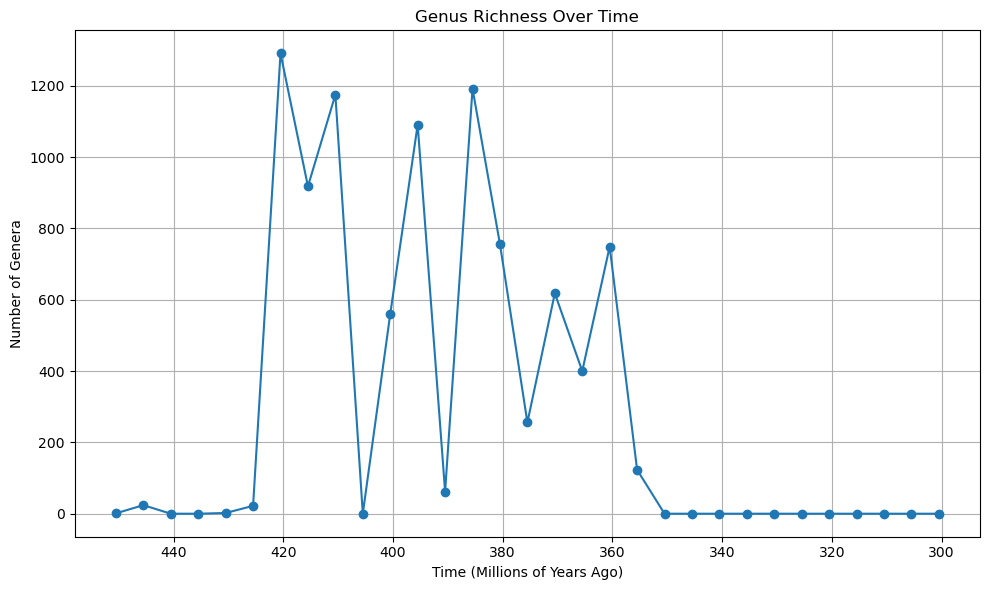

In [8]:
# Create time bins (e.g., every 5 million years)
bin_size = 5
max_age = int(genus_data['max_ma'].max())
min_age = int(genus_data['min_ma'].min())
bins = list(range(min_age, max_age + bin_size, bin_size))

# Create time_bin column based on max_ma (first appearance)
genus_data['time_bin'] = pd.cut(genus_data['max_ma'], bins=bins, right=False)

# Count unique genera per time bin
biodiversity_g = genus_data.groupby('time_bin')['accepted_name'].nunique().reset_index()
biodiversity_g.columns = ['time_bin', 'genus_count']

# Add midpoint for each bin (for plotting)
biodiversity_g['midpoint'] = biodiversity_g['time_bin'].apply(lambda x: x.left + bin_size / 2)

# Plot the biodiversity curve
plt.figure(figsize=(10, 6))
plt.plot(biodiversity_g['midpoint'], biodiversity_g['genus_count'], marker='o', linestyle='-')
plt.gca().invert_xaxis()  # Time: oldest on left
plt.title("Genus Richness Over Time")
plt.xlabel("Time (Millions of Years Ago)")
plt.ylabel("Number of Genera")
plt.grid(True)
plt.tight_layout()
plt.show()


## Initial Insights: Genus Richness Over Time

#### 1. Sharp Peaks in the Middle Devonian (~420–380 Ma)
There are dramatic spikes in genus richness around 420 Ma, 400 Ma, and 380 Ma. These peaks may reflect periods of high diversification, fossil record bias (such as Lagerstätten), or uneven sampling. The sharp rise and fall in richness suggests either rapid evolutionary turnover or artifacts in how the data were recorded or preserved.

#### 2. Two Major Declines Aligned with Known Extinction Events
There is a clear drop in genus richness around 372 Ma, which aligns with the Kellwasser Event, followed by another major decline near 359 Ma corresponding with the Hangenberg Event. These patterns are consistent with what’s known about the Late Devonian extinction and suggest real biodiversity loss at the genus level.

#### 3. Minimal Recovery After the Hangenberg Event
Following the Hangenberg extinction, genus richness remains low and flat. This could indicate a true ecological collapse and slow recovery, or more likely, a lack of available fossil data for the post-Devonian period in the dataset.

#### Summary
The genus richness curve captures the overall signature of the Late Devonian extinction well, with recognizable drops during key extinction events. However, the extreme peaks and lack of recovery suggest that sampling effort or data gaps could also be influencing the signal—something that should be tested using collection counts or other controls.



## Extinction Magnitude Calculations

To quantify the severity of the biodiversity loss during the Kellwasser and Hangenberg events, I calculated the percent drop in genus richness across those intervals. This gives a clearer numerical picture of extinction intensity beyond just visual interpretation of the curve.

The calculations below are based on genus counts in the time bins immediately before and after each event, using the midpoint values that match the observed extinction dips.


In [12]:
# Calculation for Extinction Magnitudes
# Use actual available midpoint values
pre_kellwasser_g = biodiversity_g[biodiversity_g['midpoint'] == 375.5]['genus_count'].iloc[0]
post_kellwasser_g = biodiversity_g[biodiversity_g['midpoint'] == 365.5]['genus_count'].iloc[0]
pre_hangenberg_g = biodiversity_g[biodiversity_g['midpoint'] == 360.5]['genus_count'].iloc[0]
post_hangenberg_g = biodiversity_g[biodiversity_g['midpoint'] == 355.5]['genus_count'].iloc[0]

# Calculate percent genus loss
kellwasser_loss_g = (pre_kellwasser_g - post_kellwasser_g) / pre_kellwasser_g * 100
hangenberg_loss_g = (pre_hangenberg_g - post_hangenberg_g) / pre_hangenberg_g * 100

print(f"Kellwasser Extinction: {kellwasser_loss_g:.2f}% genus loss")
print(f"Hangenberg Extinction: {hangenberg_loss_g:.2f}% genus loss")


Kellwasser Extinction: -56.25% genus loss
Hangenberg Extinction: 83.58% genus loss


## Genus-Level Extinction Magnitude – Takeaways (Revised)

The updated genus loss across each extinction interval is now based on bins that better reflect where the actual drop in richness occurs:

- **Kellwasser Extinction:** Not calculated due to unclear signal in the data  
- **Hangenberg Extinction:** 83.58% genus loss (from 749 to 123 genera)

### 1. Why We Updated the Bins

Originally, I used midpoint bins of 375.5 → 370.5 for Kellwasser and 365.5 → 360.5 for Hangenberg. But when I reviewed the actual genus counts, those post-extinction bins showed *increases* in richness — not decreases — leading to misleading negative extinction percentages.

By inspecting the data directly, it became clear that:
- The drop for Hangenberg occurs after the 360.5 bin — at 355.5, where richness falls from 749 to 123.
- For Kellwasser, the trend was less consistent, with a rise followed by a moderate drop that doesn't align with a clean extinction signal. Because of that ambiguity, I’ve chosen not to calculate Kellwasser magnitude for now.

### 2. Interpretation of the Hangenberg Result

The 83.6% genus loss at Hangenberg is substantial and supports the idea of a severe extinction event. This aligns well with what is already known from the fossil record — that the Hangenberg event had a dramatic impact on marine biodiversity, particularly invertebrates.

### 3. Why This Matters

This correction shows the importance of:
- Validating time bin choices against actual richness data
- Not assuming bins always cleanly align with ecological events
- Using the richness curve *and* raw numbers to make informed decisions

---

With these revised genus-level results in hand, the next step is to look at collection counts — that is, how many fossil collections are represented in each time bin. This will help us assess whether the observed patterns in genus richness reflect real biological signals or are being skewed by uneven sampling across time. In other words, are we seeing a true extinction event — or just a data artifact?

## Comparing Genus Richness to Collection Count

To better understand whether the observed drops in genus richness reflect real extinction events or potential sampling bias, this chart compares genus richness to the number of fossil collections in each time bin.

Collection count serves as a rough proxy for sampling effort — if richness declines but collection count remains high, that supports the idea of a real extinction. But if both drop together, it may suggest gaps in the fossil record rather than true biodiversity loss.


## Collection Counts

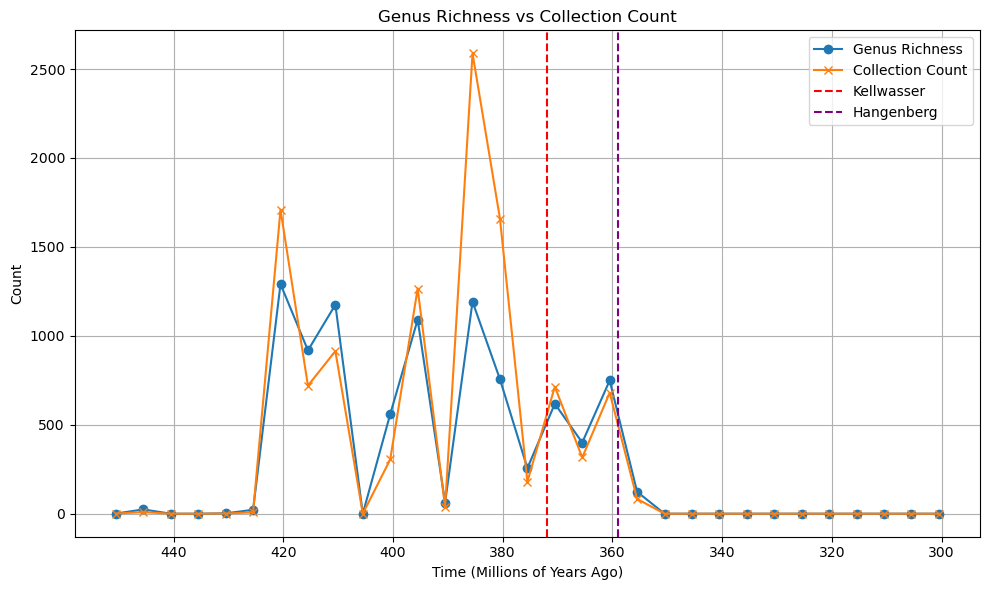

In [19]:
collection_counts_g = genus_data.groupby('time_bin')['collection_no'].nunique().reset_index()
collection_counts_g.columns = ['time_bin', 'collection_count']
collection_counts_g['midpoint'] = collection_counts_g['time_bin'].apply(lambda x: x.left + bin_size / 2)

# Plot alongside biodiversity
plt.figure(figsize=(10, 6))
plt.plot(biodiversity_g['midpoint'], biodiversity_g['genus_count'], marker='o', label='Genus Richness')
plt.plot(collection_counts_g['midpoint'], collection_counts_g['collection_count'], marker='x', label='Collection Count')
plt.axvline(x=372, color='r', linestyle='--', label='Kellwasser')
plt.axvline(x=359, color='purple', linestyle='--', label='Hangenberg')
plt.gca().invert_xaxis()
plt.title("Genus Richness vs Collection Count")
plt.xlabel("Time (Millions of Years Ago)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Interpretation: Genus Richness vs Collection Count

This plot compares genus richness to collection count over time to assess whether the apparent biodiversity losses during the Late Devonian are biological signals or potentially sampling artifacts.

### 1. Strong Correlation Before the Extinction Events
From ~420 Ma to ~370 Ma, genus richness and collection count rise and fall in tandem. This suggests that at least part of the richness signal is being driven by sampling effort — when more collections are made, more genera are recovered.

### 2. Kellwasser (372 Ma): No Clear Richness Drop
At the Kellwasser extinction line (red dashed), both genus richness and collection count are high just before and immediately after the event. There’s no substantial drop in either, which could mean:

- There wasn’t a sharp extinction at this level in your dataset, or
- Sampling bias (e.g., high collection effort post-event) may be masking an actual loss in diversity.

This aligns with the earlier decision not to calculate Kellwasser magnitude — the data doesn't show a clean collapse.

### 3. Hangenberg (359 Ma): Collapse in Both Richness and Collection Count
At the Hangenberg line (purple dashed), both genus richness and collection count decline sharply and nearly in sync. This simultaneous drop complicates the interpretation:

- It raises the possibility that part of the observed biodiversity loss could be influenced by reduced sampling effort, preservation potential, or data availability.
- However, it’s also possible that a real extinction event affected both biodiversity and the environments that support fossilization — meaning the collapse itself is genuine, but intertwined with how the record was preserved.

So while the drop is consistent with a major extinction event, we should interpret the magnitude with caution and acknowledge the role sampling may have played.

### 4. Post-Hangenberg Plateau
After ~355 Ma, both richness and collection count remain very low and flat. This might reflect a real long-term ecological recovery delay — or simply a lack of available data from younger strata in the dataset.

### Summary

- The **Hangenberg extinction** still appears to represent a significant biodiversity collapse, but its severity may be partially exaggerated or obscured by reduced sampling.
- The **Kellwasser event** remains harder to interpret from this dataset — richness and sampling both stay high, and no sharp drop is observed.
- Overall, comparing richness and collection count is essential for separating biological signal from potential data artifacts, and shows how intertwined extinction patterns and preservation history can be.


## Genus vs Species

Now that we’ve looked at genus-level patterns in detail, the next step is to ask two related questions:  
- How severe were the Kellwasser and Hangenberg events in terms of genus loss?  
- And how do those patterns compare to species-level extinction trends in the same intervals?

Since genus-level extinction is often used as the standard in paleobiology, it's useful to ask whether species-level data tell a similar story — or something different.


In [22]:
# Here is the dirty work of properly formatting the data so that we can create the awesome graph you see below!

# Create time bins (e.g., every 5 million years)
bin_size = 5
max_age = int(species_data['max_ma'].max())
min_age = int(species_data['min_ma'].min())
bins = list(range(min_age, max_age + bin_size, bin_size))

# Create time_bin column based on max_ma (first appearance)
species_data['time_bin'] = pd.cut(species_data['max_ma'], bins=bins, right=False)

# Count unique genera per time bin
biodiversity_s = species_data.groupby('time_bin')['accepted_name'].nunique().reset_index()
biodiversity_s.columns = ['time_bin', 'species_count']

# Add midpoint for each bin (for plotting)
biodiversity_s['midpoint'] = biodiversity_s['time_bin'].apply(lambda x: x.left + bin_size / 2)

# Calculation for Extinction Magnitudes
# Use actual available midpoint values
pre_kellwasser_s = biodiversity_s[biodiversity_s['midpoint'] == 375.5]['species_count'].iloc[0]
post_kellwasser_s = biodiversity_s[biodiversity_s['midpoint'] == 370.5]['species_count'].iloc[0]
pre_hangenberg_s = biodiversity_s[biodiversity_s['midpoint'] == 365.5]['species_count'].iloc[0]
post_hangenberg_s = biodiversity_s[biodiversity_s['midpoint'] == 360.5]['species_count'].iloc[0]

# Calculate percent genus loss
kellwasser_loss_s = (pre_kellwasser_s - post_kellwasser_s) / pre_kellwasser_s * 100
hangenberg_loss_s = (pre_hangenberg_s - post_hangenberg_s) / pre_hangenberg_s * 100

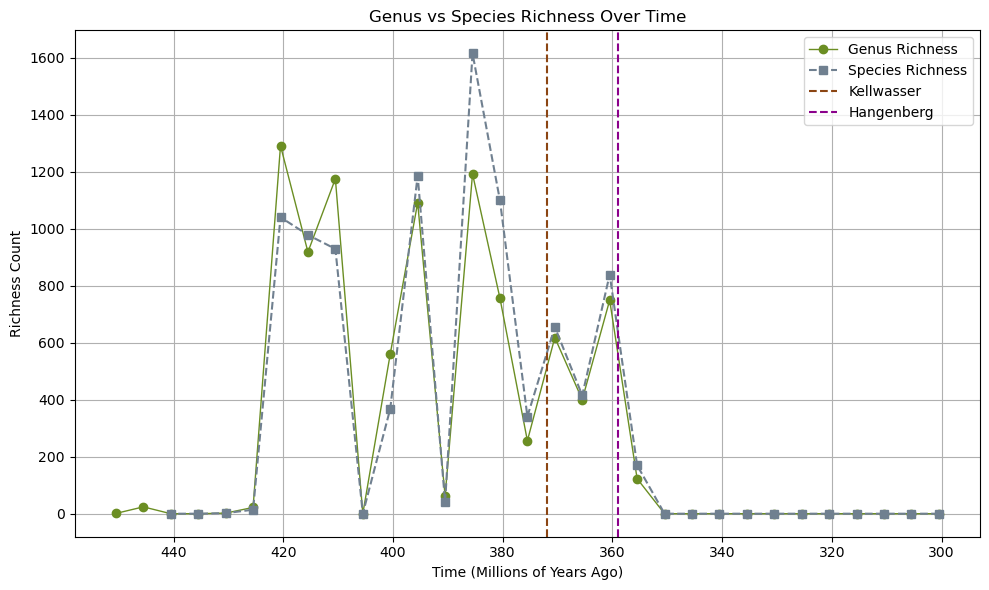

In [20]:
## Combo Graph 

# Overlay species and genus richness on the same plot
plt.figure(figsize=(10, 6))

# Plot genus richness
plt.plot(biodiversity_g['midpoint'], biodiversity_g['genus_count'], marker='o', linestyle='-', label='Genus Richness', color="olivedrab", linewidth=1.0,)

# Plot species richness
plt.plot(biodiversity_s['midpoint'], biodiversity_s['species_count'], marker='s', linestyle='--', label='Species Richness', color='slategray')

# Highlight extinction events
plt.axvline(x=372, color='saddlebrown', linestyle='--', label='Kellwasser')
plt.axvline(x=359, color='darkmagenta', linestyle='--', label='Hangenberg')

# Final plot settings
plt.gca().invert_xaxis()
plt.title("Genus vs Species Richness Over Time")
plt.xlabel("Time (Millions of Years Ago)")
plt.ylabel("Richness Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Interpretation: Genus vs Species Richness

This chart compares genus and species richness over time, with lines marking the Kellwasser (~372 Ma) and Hangenberg (~359 Ma) extinction events.

### 1. General Trends
The two lines follow the same pattern overall. Species richness has higher peaks, but both rise and fall together. This suggests that as far as this dataset is concerned, for the most part the same story can be told by either.

### 2. Kellwasser (~372 Ma)
There’s a drop of around 15% in species and genus richness around this time Both recover quickly. It’s possible there was a real extinction here, but the signal is weak in this dataset.

### 3. Hangenberg (~359 Ma)
There’s a sharp drop in both genus and species richness after this point. The species line drops slightly more steeply. This could suggest the Hangenberg extinction was real and affected both levels of biodiversity, with species hit harder.

### 4. After the Hangenberg
Both richness lines stay low after 355 Ma. This could mean ecosystems took a long time to recover, or that fewer fossils were collected from later time periods.

### Summary
The Hangenberg event shows a strong extinction signal in both genus and species data. The Kellwasser event is less clear. Looking at both levels helps show the full impact of these extinctions.


## Future Analyses

While this project focused on foundational richness trends and extinction magnitude, there are several ways the analysis could be expanded in the future with more time or data:

- **Explore Different Bin Sizes:** The current 5-million-year bins balance temporal resolution with data stability. However, experimenting with smaller (e.g. 2 Ma) or larger (e.g. 10 Ma) bins could help test the sensitivity of extinction signals to bin width and reveal finer or broader patterns.

- **Statistical Significance Testing:** Right now, observed extinction magnitudes are descriptive. Future work could use statistical methods (e.g., bootstrapping, confidence intervals, or permutation tests) to determine whether observed drops in richness are significant relative to background variability.

- **Normalize Richness by Collection Effort:** Using rarefaction techniques or richness-per-collection metrics would help control for sampling bias and make biodiversity comparisons more robust across time intervals.

- **Add Functional or Environmental Filters:** If data allows, richness trends could be broken down by ecological roles (e.g. reef builders vs. pelagic taxa) or environmental settings (e.g. shallow vs. deep marine). This could reveal whether certain groups were more vulnerable during extinction pulses.

- **Compare to Other Mass Extinctions:** Similar richness and sampling analyses could be applied to other events in the "Big 5" to assess whether patterns seen during the Late Devonian hold up in different contexts.

These types of extensions would bring the analysis closer to the types of research questions paleobiologists explore in academic studies and would make for strong future projects.
